### <b>Washington State Fatal Crash Analysis</b>
#### ---    presented by Team <b>IC23028</b>
- Members: Zizheng (Sean) Zhang, Xiaoze (Sunny) Liu, Wangxi (Allen) Pan.

In [373]:
import pandas as pd
import numpy as np
import regex as re

import datetime as dt

import plotly.graph_objects as go

import os

import seaborn as sns
import matplotlib.pyplot as plt

import statistics

pd.set_option('display.max_rows', 9)


#### <b>1. Explorative Data Analysis</b></br>
##### <b>1.1 Introduction to Datasets</b></br>
- <b>df_data_main</b>: The original data set with an expanded column that stores the zipcode of the place where the accident occured</br>
- <b> df_metadata_crashtype</b>: Derived from the table 6 of the data dictionary. It contains all the metainfo about a category of crashtype</br>
- <b> df_metadata_driver_factor</b>: Derived from the table 7 of the data dictionary. It contains all the metainfo about driver behavioral factors.
- <b> df_metadata_race</b>: Derived from data dictionary. It contains all the metainfo about the race factors.
- <b> df_metadata_zipcode_lonlat</b>: Derived from the US20Codes20201320Data.csv file, containing information about zipcodes and their geological center.

In [374]:
dir = os.path.abspath(os.path.dirname(os.getcwd())) + '/data/'

df_data_main = pd.read_csv(
    dir + '/output/data_with_zipcode.csv').drop(axis=1, labels='Unnamed: 0')
df_data_main.event_zipcode = df_data_main.event_zipcode.astype(
    str)   # convert the default float type values into str

df_metadata_crashtype = pd.read_csv(
    dir + '/output/crash_type.csv').set_index(keys='type_index')

df_metadata_driver_factor = pd.read_csv(
    dir + '/output/driver_behavioral_factors.csv').drop(labels='Unnamed: 0', axis=1)


df_metadata_race = pd.read_csv(dir + '/output/race_code.csv')

df_metadata_zipcode_lonlat = pd.read_csv(
    dir + '/output/zipcode_to_lonlat.csv').drop(labels='Unnamed: 0', axis=1)
df_metadata_zipcode_lonlat['ZIP'] = df_metadata_zipcode_lonlat['ZIP'].astype(
    object)


df_data_main.shape


C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32928\3797786673.py:3: DtypeWarning:

Columns (22,23,24,302,304) have mixed types. Specify dtype option on import or set low_memory=False.



(4132, 306)

##### <b>1.2 Data Cleaning</b>

In [375]:
# drop rows which do not have a valid event zipcode

has_no_zipcode = df_data_main.event_zipcode.map(lambda v: v == 'nan')
df_data_main = df_data_main[df_data_main.event_zipcode != 'nan']
df_data_main.shape

(4132, 306)

In [376]:
# drop rows which do not have a person zipcode

df_data_main.dzip = df_data_main.dzip.map(
    lambda n: 0 if n == 0 else 0 if pd.isna(n) else int(n)
)

# valid zip codes are all 5 digit so we filter out those with less than 5 digits
df_data_main = df_data_main[(df_data_main.dzip > 10000) & (df_data_main.dzip <= 99950)]
df_data_main.dzip = df_data_main.dzip.astype(str)
df_data_main.shape

(3996, 306)

In [377]:
# clean the age column

age_filter = filter(lambda v: v > 0 and v <= 100, df_data_main.age)
age_mean = round(np.mean(list(age_filter), dtype=float), 0)

df_data_main.age = df_data_main.age.map(
    lambda v: age_mean if v < 0 or v >= 100 else v
)

#### <b> 2. Solutions</b>
##### <b>2.1 Among drivers involved in fatal crashes, what proportion are involved in crashes in communities where they live?</b>

- This question could be addressed directy by calculating the proportion of non-resident and resident drivers.

24.3994% of the drivers are from the community where the accident occured


<AxesSubplot:title={'center':'proportion of non-resident vs. resident crashes'}>

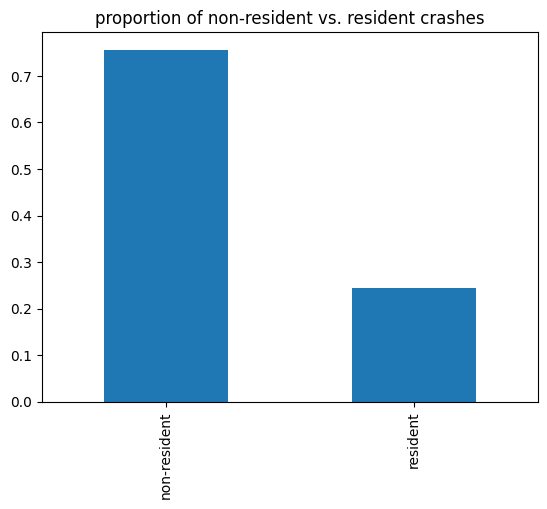

In [378]:
df_data_main['is_resident'] = df_data_main.index.map(
    lambda i: df_data_main.event_zipcode[i] == df_data_main.dzip[i]
)

df_data_main['is_driver'] = df_data_main.index.map(
    lambda i: df_data_main.loc[i, 'ptype'] == 1
)

prop = len(df_data_main[(df_data_main.is_driver) & (df_data_main.is_resident == True)]) / float(len(df_data_main[df_data_main.is_driver]))

print('{prop:.4f}% of the drivers are from the community where the accident occured'.format(
    prop=prop * 100
))

pd.Series(
    [1 - prop, prop, ], index=['non-resident', 'resident']
).plot(
    kind = 'bar', title = 'proportion of non-resident vs. resident crashes',
)

Based on our analysis, <b>24.3994%</b> of the drivers are from the community where the accident occured.

##### <b>2.2 Are there differences in the <u>crash types</u> in those crashes among “residents” versus those deemed to be not “from” the area?</b>
- We will first take a look at the types of crashes among residents versus non-residents drivers. To that end, we load the metadata regarding crash types.

In [379]:
# this dataframe stores the meta info of the variable crashtype
df_metadata_crashtype.head()

,crash_type,category
type_index,,
0,No Impact,NOT CATEGORIZED
1,Drive Off Road,SINGLE DRIVER
2,Control/Traction Loss,SINGLE DRIVER
3,"Avoid Collision with Vehicle, Pedestrian, Animal",SINGLE DRIVER
4,Specifics Other,SINGLE DRIVER


In [380]:
map_crashtype_category = {  # maps a crashtype index to its category
    k: v for k, v in zip(df_metadata_crashtype.index, df_metadata_crashtype.category)
}

map_crashtype_eng = {   # maps a crashtype index to its actual meaning
    k: v for k, v in zip(df_metadata_crashtype.index, df_metadata_crashtype['crash_type'])
}

df_data_main['crash_category'] = df_data_main.crashtype.map(map_crashtype_category)
df_data_main['crashtype_eng'] = df_data_main.crashtype.map(map_crashtype_eng)

In [381]:
# count the occurances of each crashtype for both the residenr and non-resident groups
df_data_crash = df_data_main.drop_duplicates(subset='par').groupby(
    by=['crashtype', 'is_resident']
).agg(
    case_count=pd.NamedAgg(column='par', aggfunc=len),
).reset_index()


# temporary dataframe for calculating total by is_resident
df_temp = df_data_main.groupby('is_resident').par.agg('count')
# print(df_temp)
non_resident_event_count = float(df_temp.iloc[0])
resident_event_count = float(df_temp.iloc[1])
del df_temp


def get_case_proportion(case_index: int, crash_dataframe: pd.DataFrame) -> float:
    is_resident = crash_dataframe.loc[case_index, 'is_resident']
    case_count = crash_dataframe.loc[case_index, 'case_count']
    if is_resident:
        ratio = case_count / resident_event_count
    else:
        ratio = case_count / non_resident_event_count
    return ratio


df_data_crash['case_proportion'] = df_data_crash.index.map(
    lambda i: get_case_proportion(i, df_data_crash)
)

df_data_crash[:8]

,crashtype,is_resident,case_count,case_proportion
0,0,False,18,0.005958
1,0,True,4,0.004103
2,1,False,240,0.079444
3,1,True,95,0.097436
4,2,False,99,0.032771
5,2,True,33,0.033846
6,3,False,2,0.000662
7,5,False,1,0.000331


- From previous analysis we know that the occurences of non-resident driver car crash outnumbers that of resident drivers', comparison based on counts of occurences thus cannot clearly show the different patterns among resident and non-resident drivers.
- The following pivot table compares the proportion of crashtypes in both the driver groups and shows the difference of the proportions. It is sorted in decsending order by the proportional difference.

In [382]:
df_crash_pivoted = df_data_crash.pivot(
    index='crashtype', columns='is_resident', values=['case_proportion']
)

df_crash_pivoted['prop_diff'] = df_crash_pivoted[('case_proportion', False)] - df_crash_pivoted[('case_proportion', True)]
df_crash_pivoted.sort_values(by='prop_diff', ascending=False, inplace=True)
df_crash_pivoted = df_crash_pivoted.fillna(0)

df_crash_pivoted['crashtype_eng'] = df_crash_pivoted.index.map(map_crashtype_eng)
df_crash_pivoted[:5]

case_proportion           prop_diff               crashtype_eng
is_resident           False      True                                      
crashtype                                                                  
50                 0.066534  0.048205  0.018329  Lateral Move (Left/Right) 
98                 0.050976  0.042051  0.008925           Other Crash Type 
28                 0.007282  0.001026  0.006257     Decelerating (Slowing) 
66                 0.016220  0.010256  0.005963            Specifics Other 
52                 0.006951  0.003077  0.003874            Specifics Other

- According to the pivot table, the largest difference of case proportion appears in crash types <b>50, 98, 28, 25,52</b>, which are <b>Lateral Move (Left/Right), Other Crash Type, Decelerating (Slowing), and Slower, Going Straight</b>.</br>
- Filtering out <b>Other Crash Type</b> and <b>Specifics Other</b>, which represent uncategorized crash types, we then conclude that <b>Lateral Move, Decelerating, and Slower, Going Straight</b> are the most frequent crash types.

<AxesSubplot:xlabel='crashtype'>

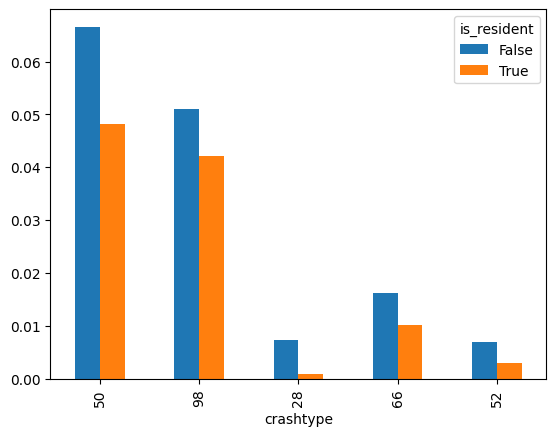

In [383]:
df_crash_pivoted.case_proportion[:5].plot(kind = 'bar')

<AxesSubplot:title={'center':'distribution of crashtype - resident group'}, xlabel='crashtype'>

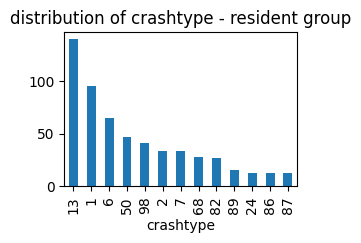

In [384]:
resident_crashes = df_data_crash[
        df_data_crash.is_resident
    ].set_index(
        drop=True, keys='crashtype'
    )


non_resident_crashes = df_data_crash[
        df_data_crash.is_resident == False
    ].set_index(
        drop=True, keys='crashtype'
    )


# filter the  crash types which have their count of occurences no less than the upper quartile 
resident_crashes[
    resident_crashes.case_count >= resident_crashes.case_count.quantile(.75)
].case_count.sort_values(
    ascending=False
).plot(
    kind = 'bar', title = 'distribution of crashtype - resident group', figsize=(3,2)
)

<AxesSubplot:title={'center':'distribution of crashtype - non-resident group'}, xlabel='crashtype'>

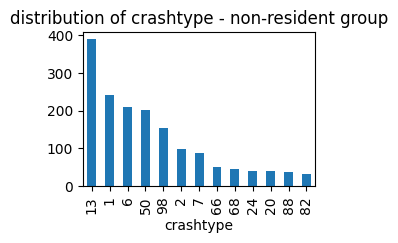

In [385]:
non_resident_crashes[
    non_resident_crashes.case_count >= non_resident_crashes.case_count.quantile(.75)
].case_count.sort_values(
    ascending=False
).plot(
    kind = 'bar', title = 'distribution of crashtype - non-resident group', figsize=(3,2)
)

- Both the bar braph show pattern of Pareto distribution - a small number of crash types account for most of the accidents.
- Comparing the two distributions, we found that the first few crash types in both groups are the same, which are <b>pedestrian/animal, drive off road (right road side departure), drive off road (left road side departure), and lateral move (left/right)</b>. These crash types account for some <B>50%</b> of the crashes.
- On the other hand, tail part distribution of crash types differ from each of the groups.

##### <b>2.3 Are there differences in the <u>behavior factors</u> in those crashes among “residents” versus those deemed to be not “from” the area?

In [386]:
df_metadata_driver_factor = df_metadata_driver_factor.loc[
    df_metadata_driver_factor.effect_end >= df_data_main.year.min(), :
]   # filter out factors that do not take effect during the timeframe of the dataset

df_metadata_driver_factor = df_metadata_driver_factor.sort_values(
    by='factor_index', ascending=True).reset_index(drop=True)
df_metadata_driver_factor = df_metadata_driver_factor[df_metadata_driver_factor.effect_start <= df_data_main.year.min()]
df_metadata_driver_factor

,factor_index,driver_factor,effect_start,effect_end,factor_category
0,0,No factors identified for this driver,0,9999,default
1,4,Reaction to/Failure to take Drugs/Medication,0,9999,Physical/Mental Condition
2,6,Careless Driving,2012,9999,Physical/Mental Condition
3,8,Aggressive Driving Road Rage,2004,9999,Physical/Mental Condition
...,...,...,...,...,...
76,94,Emergency Medical Service Personnel,0,2018,Possible Distraction Inside Vehicle
77,95,Fire Personnel,0,2018,Possible Distraction Inside Vehicle
78,96,Tow Operator,0,2018,Possible Distraction Inside Vehicle
79,97,"Transportation i.e. maintenance workers, safte...",0,2018,Possible Distraction Inside Vehicle


Note that for each factor index, its meaning may change over time. We thus encoded two columns, <b>effect_start</b> and <b>effect_end</b> to record the start year and the end year of that meaning. Values 0 and 9999 imply no time boundary for respective columns.

In [387]:
def sum_driver_factor(index: int, df: pd.DataFrame):
    # first conerted to int to remove trailing decimal zero
    joint = '|'.join(df.loc[index, 'drf1':'drf4'].astype(int).astype(str))
    return re.sub(pattern=r'\|0', string=joint, repl='')


df_data_main.loc[:, 'drf1':'drf4'] = df_data_main.loc[:, 'drf1':'drf4'].fillna(0)     # in this case, na suggests no factor rather than the missing of value
df_data_main['drf'] = df_data_main.index.map(lambda i:  sum_driver_factor(i, df_data_main))


# drop the original component columns as we already acquired the summed up one
df_data_main.drop(axis=1, labels=['drf1', 'drf2', 'drf3', 'drf4'], inplace=True)

In [388]:
def get_factor_levels(col):
    res = []
    for val in col:
        val_split = val.split('|')
        for v in val_split:
            res.append(v)
    return sorted(np.unique(res))   # sort the levels


# store the distinct values of drf
drf_distinct_vals = get_factor_levels(df_data_main.drf)


def factor_to_dummy(col, level):
    col_len = len(col)

    data_dict = {
        lv: [0] * col_len for lv in level
    }
    for i in range(col_len):
        keys = col[i].split('|')
        for key in keys:
            data_dict[key][i] = 1
    return pd.DataFrame(data_dict)


df_drf_dist = factor_to_dummy(df_data_main.drf.values, drf_distinct_vals)
df_drf_dist.insert(0, 'is_resident', df_data_main.is_resident)
df_drf_dist = df_drf_dist.groupby('is_resident').agg('sum')
# get corresponding proportion
df_drf_dist.loc[0, :] = df_drf_dist.loc[0, :] / sum(df_drf_dist.loc[0, :])
df_drf_dist.loc[1, :] = df_drf_dist.loc[1, :] / sum(df_drf_dist.loc[1, :])
df_drf_dist = df_drf_dist.transpose()


df_drf_dist.columns = ['non-resident', 'resident']
df_drf_dist['prop_diff'] = df_drf_dist['non-resident'] - df_drf_dist['resident']
df_drf_dist.sort_values(by='prop_diff', inplace=True, ascending=False)
df_drf_dist.set_index(pd.Series(df_drf_dist.index, name='drf', dtype=int), inplace=True)
df_drf_dist[:4]

,non-resident,resident,prop_diff
drf,,,
28,0.070527,0.059838,0.010690
39,0.033970,0.025355,0.008615
38,0.061792,0.055781,0.006011
8,0.012617,0.010142,0.002475


<AxesSubplot:title={'center':'Proportion of Behavioral Factors across Two Groups'}, xlabel='drf'>

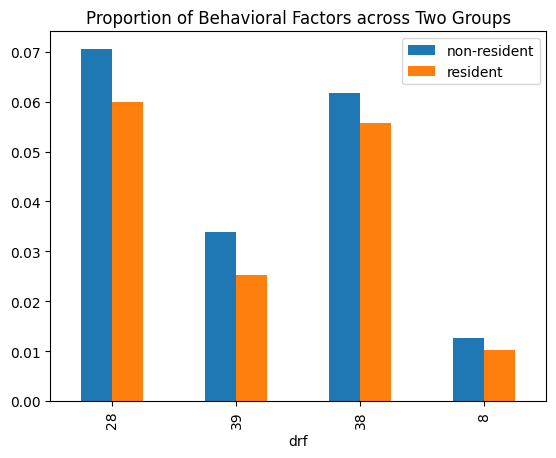

In [389]:
df_drf_dist.drop(labels = 'prop_diff', axis=1)[:4].plot(kind='bar', title='Proportion of Behavioral Factors across Two Groups')

- The table above suggests that compared to resident drivers, non-resident drviers are much more likely to encounter accidents that result from the behavioral factor <b>28</b>, that is, <b>improper lane use</b>.

The following blocks focus on the analysis of <b>distraction factors</b>. As the distraction index 0 means not distracted, and index 96 not reported, we merge these two categories into one.

In [390]:
df_data_main.loc[:, 'distract1': 'distract6'] = df_data_main.loc[:, 'distract1': 'distract6'].fillna(0)


def sum_distract_factors(ind: int, df: pd.DataFrame):
    return re.sub(string="|".join(df.loc[ind, 'distract1': 'distract6'].astype(int).astype(str)), pattern=r'\|0', repl='')


df_data_main['distract'] = df_data_main.index.map(
    lambda i: re.sub(string=sum_distract_factors(i, df_data_main), repl='0', pattern='96')
)

df_data_main.drop(axis=1, labels=['distract1', 'distract2', 'distract3', 'distract4', 'distract5', 'distract6'], inplace=True)
df_data_main.distract.value_counts(ascending=False)

0       3443
92       308
93       140
12        20
        ... 
5|93       1
14         1
3|6        1
97         1
Name: distract, Length: 20, dtype: int64

In [391]:
distinct_distract = get_factor_levels(df_data_main.distract)

df_distract = factor_to_dummy(df_data_main.distract.values, distinct_distract)
df_distract.insert(0, column='is_resident', value=df_data_main.is_resident)
df_distract = df_distract.groupby('is_resident').agg('sum')

df_distract.loc[0, :] = df_distract.loc[0, :] / sum(df_distract.loc[0, :])
df_distract.loc[1, :] = df_distract.loc[1, :] / sum(df_distract.loc[1, :])

df_distract = df_distract.transpose()
df_distract.columns = ['non-resident', 'resident']
df_distract['prop_diff'] = df_distract['non-resident'] - df_distract['resident']
df_distract.sort_values(by='prop_diff', inplace=True, ascending=False)
df_distract.set_index(
    pd.Series(df_distract.index, name='distract_factor', dtype=int), inplace=True
)

df_distract[:5]

,non-resident,resident,prop_diff
distract_factor,,,
93,0.038553,0.026652,0.011901
1,0.004777,0.002132,0.002644
12,0.005800,0.003198,0.002602
5,0.001365,0.000000,0.001365
13,0.001365,0.000000,0.001365


- The analysis of distract factors shows that compared to resident drivers, non-resident drivers in fatal crash event are more likely to be involved with disctract factors 93, 1, 12, 5, and 13, which are <b>inattention, looked but did not see, distracted by outside person, talking or listening to phone, and eating or drinking.

##### <b>2.4 Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?</b>

- We would first check if drivers with certain zip codes are more likely to be involved in fatal crash events..

In [392]:
df_data_by_zip = df_data_main[df_data_main.is_driver == True].groupby('dzip').agg(
    case_count=pd.NamedAgg(column='par', aggfunc=len),
    case_proportion=pd.NamedAgg(column='par', aggfunc=lambda c: len(c) / len(df_data_main.index))
)
df_data_by_zip.sort_values(ascending=False, inplace=True, by='case_proportion')

df_data_by_zip.describe()

,case_count,case_proportion
count,693.000000,693.000000
mean,5.766234,0.001443
std,7.252280,0.001815
min,1.000000,0.000250
25%,1.000000,0.000250
50%,2.000000,0.000501
75%,8.000000,0.002002
max,47.000000,0.011762


In [393]:
 #  filtering mean + 3 * sigma based on case count
df_highrisk_dzip = df_data_by_zip[
        df_data_by_zip.case_count >= df_data_by_zip.case_count.mean() + 3 * df_data_by_zip.case_count.std()	
    ]            

df_highrisk_dzip.index

Index(['99301', '98444', '98387', '98003', '98951', '98837', '98404', '98391',
       '98258', '98901', '98223', '98584', '99206', '98022'],
      dtype='object', name='dzip')

In [394]:
df_highrisk_dzip.head()

,case_count,case_proportion
dzip,,
99301,47,0.011762
98444,43,0.010761
98387,35,0.008759
98003,32,0.008008
98951,32,0.008008


<AxesSubplot:ylabel='case_count'>

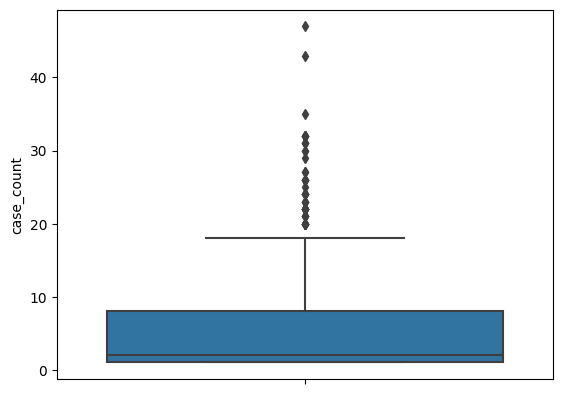

In [395]:
sns.boxplot(y=df_data_by_zip.case_count)

<AxesSubplot:xlabel='case_count', ylabel='Count'>

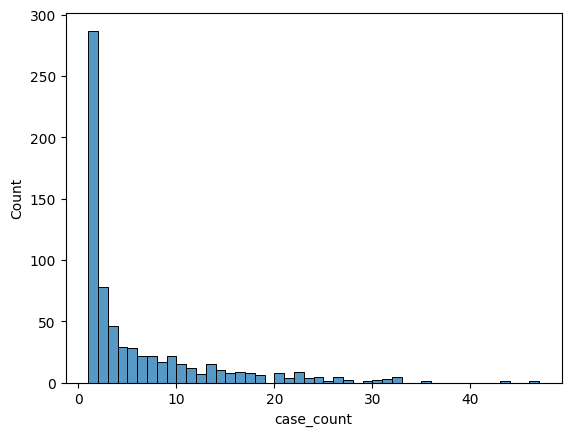

In [396]:
sns.histplot(x=df_data_by_zip.case_count, binwidth=1)

- Both the boxplot and histogram suggest that the distribution of case proportion across zipcodes follows Pareto distribution. This implies that the few areas account for most of the risky drivers. 
- We conclude that <b>there are specific zip codes that produce risky drivers at a significantly higher rate</b>.
- The high-risk zip codes are: <b>'98444', '98584', '99301', '98404', '98003', '98902', '98022', '98901',
       '98387', '98391', '98837'</b>.

In [397]:
df_metadata_zipcode_lonlat.head()

,ZIP,LAT,LNG
0,10001,40.750633,-73.997177
1,10002,40.715775,-73.986212
2,10003,40.731829,-73.989181
3,10004,40.688630,-74.018244
4,10005,40.706027,-74.008835


In [398]:
map_zipcode_lonlat = {
    str(k):(lon, lat) for k,lon,lat in zip(
        df_metadata_zipcode_lonlat['ZIP'].values.astype(str), 
        df_metadata_zipcode_lonlat['LNG'].values, 
        df_metadata_zipcode_lonlat['LAT'].values,
    )
}


df_highrisk_dzip['lng'] = df_highrisk_dzip.index.map(lambda z: map_zipcode_lonlat[z][0])
df_highrisk_dzip['lat'] = df_highrisk_dzip.index.map(lambda z: map_zipcode_lonlat[z][1])

df_highrisk_dzip.head()

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32928\518014722.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32928\518014722.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,case_count,case_proportion,lng,lat
dzip,,,,
99301,47,0.011762,-118.953781,46.379233
98444,43,0.010761,-122.448831,47.153041
98387,35,0.008759,-122.388908,47.060925
98003,32,0.008008,-122.316969,47.304801
98951,32,0.008008,-120.513604,46.456028


In [416]:
mapbox_access_token = 'pk.eyJ1IjoiY2hhY29ubmUiLCJhIjoiY2xhYm5zYWIyMDI0ZjN2bzF0aDFibTJncSJ9.PyW8zQZ-927g0cgYNIsgpg'

class_map_data = go.Scattermapbox(
        lon = df_highrisk_dzip.lng,
        lat = df_highrisk_dzip.lat,
        # text = class_sample['Name'],
        # hoverinfo='text',
        mode = 'markers',
        marker = dict(
                    #color = df_highrisk_dzip.case_count.values,
                    symbol = 'square',
                    opacity = 1,
                    size = 3,
                )
)

mb = go.layout.Mapbox(
            accesstoken=mapbox_access_token,
            zoom=4.7,
            center = {'lon':df_highrisk_dzip.lng.mean(), 'lat':df_highrisk_dzip.lat.mean()},
        )

class_map_layout = go.Layout(
        title = 'Crash event distribution',
        mapbox= mb
    )

class_map = go.Figure(data=class_map_data, layout=class_map_layout)
class_map.show()

Next, we want to analyze if fatal crash events are more likely to happen in certain areas.

In [400]:
evnt_count_by_event_zip = df_data_main.drop_duplicates(
        subset='par'
    ).groupby(
        'event_zipcode'
    ).agg(
        'count'
    ).par

<AxesSubplot:xlabel='par', ylabel='Count'>

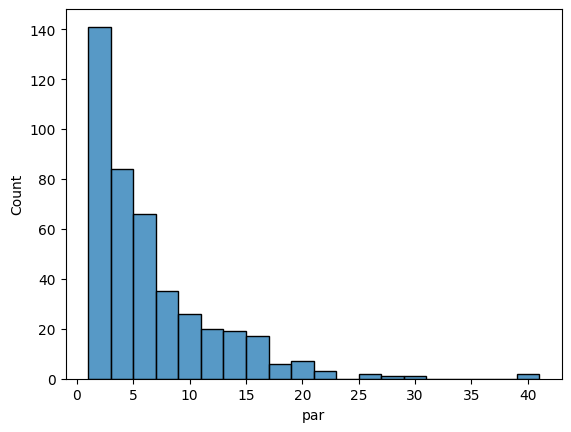

In [401]:
sns.histplot(x=evnt_count_by_event_zip, binwidth=2, )

In [402]:
highrisk_event_zipcode =  evnt_count_by_event_zip[
        evnt_count_by_event_zip > evnt_count_by_event_zip.mean() + 3 * evnt_count_by_event_zip.std()
    ].index.values.astype(str)

highrisk_event_zipcode

array(['98032', '98444', '98584', '98948', '98951', '99301'], dtype='<U5')

In [403]:
overlap_zipcode = list(
    filter(lambda zipcode: zipcode in df_highrisk_dzip, highrisk_event_zipcode)
)
overlap_zipcode

[]

##### <b>2.5 What are the population demographics of these high-risk driver producing ZIP Codes?</b>

In [404]:
# filter records related to risky zipcodes

# create a column to indicate whether the driver's community zipcode is considered high-risk
df_data_main['is_risky_dzip'] = df_data_main.index.map(lambda index: df_data_main.loc[index, 'dzip'] in df_highrisk_dzip.index)

df_data_risky_zipcode = df_data_main.loc[
    df_data_main.index.map(lambda index: df_data_main.loc[index, 'is_risky_dzip'] and df_data_main.loc[index, 'is_driver']), :
]

print(df_data_risky_zipcode.shape)
df_data_risky_zipcode.head()

(467, 303)


,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,holiday,county,...,IntCoRoadName,IntCoMP,event_zipcode,is_resident,is_driver,crash_category,crashtype_eng,drf,distract,is_risky_dzip
13,2017,10,E632128,8.0,01/08/2017,19:05,8,1,0.0,45,...,NaN,NaN,98546,False,True,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Lateral Move (Left/Right),28,0,True
40,2017,26,E635844,1.0,01/23/2017,17:19,23,1,0.0,21,...,NaN,NaN,99344,False,True,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Lateral Move (Going Straight),0,0,True
41,2017,26,E635844,1.0,01/23/2017,17:19,23,1,0.0,21,...,NaN,NaN,99344,False,True,MISCELLANEOUS,Other Crash Type,0,0,True
51,2017,34,E637343,1.0,01/24/2017,23:20,24,1,0.0,77,...,NaN,NaN,98951,False,True,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Specifics Other,0,0,True
59,2017,40,E633587,25.0,01/16/2017,15:51,16,1,0.0,33,...,NaN,NaN,98022,True,True,SINGLE DRIVER,Drive Off Road,0,0,True


Text(0.5, 1.0, 'age distribution')

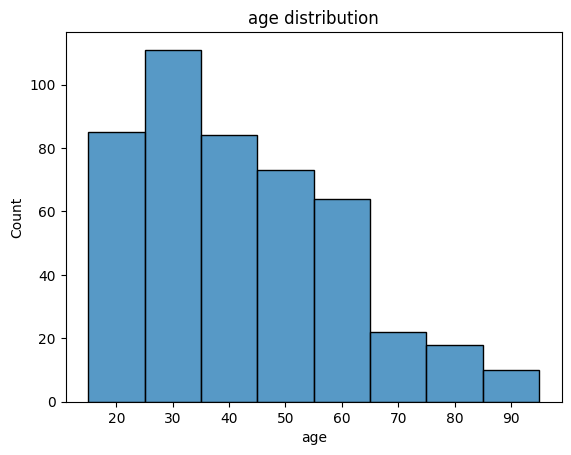

In [405]:
sns.histplot(x=df_data_risky_zipcode.age, binwidth=10, ).set_title('age distribution')

In [406]:
df_data_risky_zipcode.age.describe()

count    467.000000
mean      41.561028
std       17.494758
min       15.000000
25%       27.000000
50%       38.000000
75%       54.000000
max       89.000000
Name: age, dtype: float64

- As the histogram of age suggests, age distribution of risky drivers is significantly skewed to the right. <b>Drivers under the age of 36 account for 50% of the total crash events</b>.

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32928\731702045.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:title={'center':'sex distribution'}, xlabel='sex'>

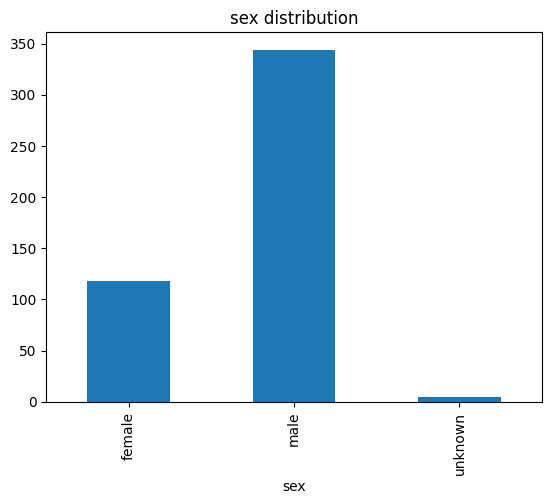

In [407]:
df_data_risky_zipcode.sex = df_data_risky_zipcode.sex.map(
        lambda s: 3 if s != 1 and s != 2 else s
    ).map(
        {1: 'male', 2: 'female', 3: 'unknown'}
    )

df_data_risky_zipcode.groupby('sex').agg('count').par.plot(kind='bar', title = 'sex distribution', )

- Most of the drivers who come from the high-risk zip code areas are male.
- Lastly, we analyze the demographical features of these high-risk instances.

#### <b>3. Additional Questions</b>
##### <b>3.1 Are there any patterns of the fatal crashes over time?</b>

In [408]:
datetime_pat = r'([0-9]{,2})/([0-9]{,2})/([0-9]{,4})'


def get_day_mon_year(s:str):
    res = re.match(pattern = datetime_pat, string= s)
    if res:
        return dt.datetime(month=int(res.group(1)), day = int(res.group(2)), year= int(res.group(3)))
    else:
        raise Exception(s + '\t is not in correct format!')

df_data_main.crash_dt.map(lambda v : not re.match(pattern = datetime_pat, string = v)).sum()

0

In [409]:
df_data_main.crash_dt = df_data_main.crash_dt.map(get_day_mon_year)

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32928\84235327.py:10: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



Text(0.5, 1.0, 'Monthly Count of Fatal Crashes')

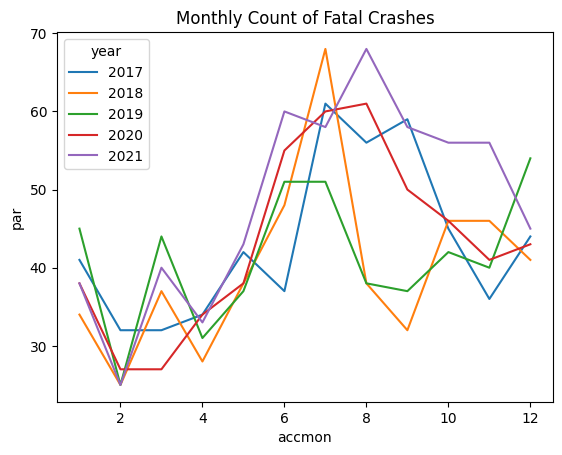

In [410]:
df_event_count_monthly = df_data_main.drop_duplicates(
    subset = 'par'
).groupby(
    ['year', 'accmon']
).agg(
    'count'
)


sns.lineplot(
    data = df_event_count_monthly, x='accmon', y='par', hue = 'year', palette = sns.color_palette(),
).set_title(
    'Monthly Count of Fatal Crashes'
)

- Based on the line plot above it can be seen that <b>there are seasonality in the number of fatal crashes throughout a year</b>.
- <b>Feburary was the month when there are fewest number of crashes in a year</b>.
- <b>The monthly total of fatal crashes peaks in July or August</b>.
- July and August are the months when temperature in Washington state reaches its yearly maximum and precipitation reaches its minimum. <b>People tend to go out in good weathers, which in turn contribute to the increase of crash accidents in these two months</b>. 
- The logic also explains why in Feburary there is very few crash accidents - because in Feburary the temperature in Washington state reaches yearly minimun while precipitation is very high. <b>Averse weather reduces people's willingess of travelling and going out, thereby reducing the number of crash events</b>.

#### <b>4. Conclusion</b>
##### <b>Non-resident drivers are more likely to encounter fatal crash accidents</b>, because:
- They may not be familiar with the road and environmental condition of the place where they are driving.
- They are more likely to be inattentive, which results from their unfamiliarity with the surroundings.
- They are more likely to be distracted, as the unfamiliar environment could be appealing to them.

##### <b> Crash types feature long tail distribution</b>:
- Few crash types account for most of the accidents. They are 
- To protect drivers and pedestrians, relevant parties can focus on the few types which account for most of the crashes.


##### <b>Output Cleaned Dataset for Visualization</b>

In [411]:
df_data_main.to_csv(dir + 'output/data_vis.csv')

df_data_main.loc[df_data_main.dzip.map(lambda dz: dz in df_highrisk_dzip.values), :].to_csv(dir + 'output/data_highrisk_area.csv')

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32928\1283226902.py:3: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

